In [1]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def color_string(order, s : str):
    if order in [6, 8]:
        return bcolors.FAIL + s + bcolors.ENDC
    else:
        return s

# Catan Structure
## Tile
    - Gift
    - Sea
    - Uncharted
    - Harbor

    every tile has draw() method
    Gift is fundamental piece for this map generator. After generating the map, type and number of every each gift should be assigned.
    Both of Sea and Uncharted are not resource so they don't have type or number, but Uncharted has potential to be resource and they have a diffferent draw() method.
    Harbor is dependent on Gift and has resource type but don't have number and coordinate.


In [2]:
from __future__ import annotations
from typing import List, Dict, Tuple
from abc import ABC, abstractmethod
from enum import Enum

import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Polygon

class CatanObjectType(Enum):
    Gift = 0
    Harbor = 1

class CatanGiftType(Enum):
    Default = -1
    Resource = 0
    Sea = 1
    Uncharted = 2

class ResourceType(Enum):
    Default = -1
    Tree = 0
    Grain = 1
    Steel = 2
    Sheep = 3
    Ground = 4

# Use "Visitor" design pattern for drawing each CatanObject
# Visitor is a behavioral design pattern that lets you separate algorithms from the objects on which they operate.
    
class CatanObject(ABC):
    def __init__(self, type: CatanObjectType):
        self._type = type
    
    @abstractmethod
    def draw(self, obj: DrawVistor):
        pass

class Gift(CatanObject):
    def __init__(self, coord: tuple, type=CatanGiftType.Default):
        super().__init__(CatanObjectType.Gift)
        self.gift_type = type
        self.coord = coord
    
    def draw(self, obj: DrawVistor):
        obj.draw_default(self)

class Resource(Gift):
    odds = {
        -1 : 0,
        2 : 1,
        3 : 2,
        4 : 3,
        5 : 4,
        6 : 5,
        8 : 5,
        9 : 4,
        10 : 3,
        11 : 2,
        12 : 1
    }
    
    def __init__(self, coord: tuple, number: int=-1, resource_type = ResourceType.Default):
        assert(number in Resource.odds.keys())
        super().__init__(coord, CatanGiftType.Resource)
        self.number = number
        self.odd = Resource.odds[self.number]
        self.resource_type = resource_type
    
    def draw(self, obj: DrawVistor):
        obj.draw_resource(self)

class Sea(Gift):
    def __init__(self, coord: tuple):
        super().__init__(coord, CatanGiftType.Sea)
    
    def draw(self, obj: DrawVistor):
        obj.draw_sea(self)

class Uncharted(Gift):
    def __init__(self, coord: tuple):
        super().__init__(coord, CatanGiftType.Uncharted)
        
    def draw(self, obj: DrawVistor):
        obj.draw_uncharted(self)

class Harbor(CatanObject):
    def __init__(self, resource: Resource, edge=-1):
        super().__init__(CatanObjectType.Harbor)
        self.resource = resource
        self.edge = edge
    
    def draw(self, obj: DrawVistor):
        obj.draw_harbor(self)

class DrawVistor(ABC):
    def __init__(self):
        self.fig, self.ax = None, None

    @abstractmethod
    def draw_default(self, obj: Gift):
        pass

    @abstractmethod
    def draw_resource(self, obj: Resource):
        pass

    @abstractmethod
    def draw_sea(self, obj: Sea):
        pass

    @abstractmethod
    def draw_uncharted(self, obj: Uncharted):
        pass

    @abstractmethod
    def draw_harbor(self, obj: Harbor):
        pass    

    def reset(self):
        self.fig, self.ax = plt.subplots(1)
        self.ax.set_aspect('equal')

    def display(self):
        plt.autoscale(enable = True)
        plt.show()

In [9]:
import numpy as np
import math

class CatanDrawingObject(DrawVistor):
    def __init__(self, radius = np.sqrt(1/3)):
        super().__init__()
        self.radius = radius

    def __transform(self, row: int, col: int):
        assert(row >= 0 and col >= 0)
        
        x = (2 * col + row) * self.radius * math.cos(math.radians(30))
        y = row * 3 / 2 * self.radius
        
        return x, y

    def draw_default(self, obj: Gift):
        hex = RegularPolygon(self.__transform(*obj.coord), numVertices=6, radius=self.radius, alpha=1, edgecolor='k', facecolor='k')
        self.ax.add_patch(hex)
        plt.text(*self.__transform(*obj.coord), "{}".format(obj.coord), fontsize = 15, ha='center', va='center', color='w')

    def draw_resource(self, obj: Resource):
        fc, tc, t, w = 'w', 'k', '{}\n'.format(obj.number) + '.' * obj.odd, 'normal'

        if obj.resource_type == ResourceType.Tree:
            fc = 'green'
            tc = "k"
        elif obj.resource_type == ResourceType.Grain:
            fc = 'gold'
            tc = "k"
        elif obj.resource_type == ResourceType.Steel:
            fc = 'steelblue'
            tc = "w"
        elif obj.resource_type == ResourceType.Sheep:
            fc = 'lime'
            tc = "k"
        elif obj.resource_type == ResourceType.Ground:
            fc = 'brown'
            tc = "w"
        else:
            fc = 'w'
            tc = "b"
            t = ""
        
        if obj.number == 6 or obj.number == 8:
            w = 'bold'
            tc = 'red'
            
        hex = RegularPolygon(self.__transform(*obj.coord), numVertices=6, radius=self.radius, alpha=1, edgecolor='k', facecolor=fc)
        self.ax.add_patch(hex)
        plt.text(*self.__transform(*obj.coord), t, fontsize = 15, ha='center', va='center', color=tc, weight=w)
        
    def draw_sea(self, obj: Sea):
        hex = RegularPolygon(self.__transform(*obj.coord), numVertices=6, radius=self.radius, alpha=1, edgecolor='k', facecolor='blue')
        self.ax.add_patch(hex)
        
    def draw_uncharted(self, obj: Uncharted):
        hex = RegularPolygon(self.__transform(*obj.coord), numVertices=6, radius=self.radius, alpha=1, edgecolor='k', facecolor='w')
        self.ax.add_patch(hex)
        plt.text(*self.__transform(*obj.coord), "?", fontsize = 15, ha='center', va='center', color='k')
        
    def draw_harbor(self, obj: Harbor):
        row, col = obj.resource.coord
        x, y = self.__transform(row, col)
        vertices = [
            (x, y + self.radius), 
            (x + self.radius * math.cos(math.radians(30)), y + self.radius * math.cos(math.radians(60))),
            (x + self.radius * math.cos(math.radians(30)), y - self.radius * math.cos(math.radians(60))),
            (x, y - self.radius),
            (x - self.radius * math.cos(math.radians(30)), y - self.radius * math.cos(math.radians(60))),
            (x - self.radius * math.cos(math.radians(30)), y + self.radius * math.cos(math.radians(60)))
        ]

        vertex = [
            (row+1, col),
            (row, col+1),
            (row-1, col+1),
            (row-1, col),
            (row, col-1),
            (row+1, col-1)
        ]

        triangle = Polygon(vertices[obj.edge:obj.edge+2] + [self.__transform(*vertex[obj.edge])])
        self.ax.add_patch(triangle)

In [10]:
from collections import Counter
import random

random.seed(0)

class Board(ABC):
    def __init__(self, size: tuple):
        assert(len(size) == 2)
        assert(all(s > 0 for s in size))
        self.size = size
        self.drawer = CatanDrawingObject()

        self.default : Dict[Gift] = {}
        self.resources : Dict[Resource] = {}
        self.seas : Dict[Sea] = {}
        self.uncharted : Dict[Uncharted] = {}
        self.harbors : Dict[Harbor] = {}
        
        rows, cols = self.size
        for row in range(rows):
            for col in range(cols):
                self.default[(row, col)] = Gift(coord=(row, col))
    
    def draw(self, default_gift=True):
        self.drawer.reset()
        if default_gift:
            for gift in self.default.values():
                gift.draw(self.drawer)

        for resource in self.resources.values():
            resource.draw(self.drawer)

        for sea in self.seas.values():
            sea.draw(self.drawer)

        for uncharted in self.uncharted.values():
            uncharted.draw(self.drawer)

        for harbor in self.harbors.values():
            harbor.draw(self.drawer)
        self.drawer.display()

    @abstractmethod
    def generate(self, resource_types: Counter, dice_numbers: Counter) -> bool:
        pass
    
class FogIsland(Board):
    def __init__(self, rules):
        size = (8, 8)
        super().__init__(size)

        self.rules = rules
        
        resource_coords = [
                    (0, 4), (0, 5), (0, 6),
                    (1, 2), (1, 3), (1, 4), (1, 5), (1, 6),
                    (2, 5), (2, 6),
                    (6, 0), (6, 1), (6, 2), (6, 3),
                    (7, 0), (7, 1), (7, 2),
        ]
    
        uncharted_coords = [
                        (3, 0), (3, 1), (3, 2), (3, 3),
                        (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6),
                        (5, 5)
        ]
        
        sea_coords = [
            (0, 3),
            (2, 1), (2, 2), (2, 3), (2, 4),
            (3, 4), (3, 5), (3, 6),
            (5, 0), (5, 1), (5, 2), (5, 3), (5, 4),
            (6, 4),
            (7, 3)
        ]

        harbor_locations = [
            (6, 3, 0)
        ]
        
        for row, col in resource_coords:
            self.resources[(row, col)] = Resource(coord=(row, col))
            del self.default[(row,col)]
        
        for row, col in uncharted_coords:
            self.uncharted[(row, col)] = Uncharted(coord=(row, col))
            del self.default[(row,col)]
            
        for row, col in sea_coords:
            self.seas[(row, col)] = Sea(coord=(row, col))
            del self.default[(row,col)]
        
        for row, col, edge in harbor_locations:
            self.harbors[(row,col,edge)] = Harbor(self.resources[(row,col)], edge)


    def __unfold_dict(self, counter: Counter) -> list:
        res = []
        for key, cnt in counter.items():
            res += [key for _ in range(cnt)]
        return res

    def check(self):
        rows, cols = self.size
        for row in range(-1, rows+1):
            for col in range(cols+1):
                target_resource = self.resources.get((row, col), Resource(coord=(row, col)))
                first_resource = self.resources.get((row+1, col-1), Resource(coord=(row+1, col-1)))
                second_resource = self.resources.get((row, col-1), Resource(coord=(row, col-1)))
                
                for rule in self.rules:
                    if not rule(target_resource, first_resource, second_resource):
                        return False

                first_resource = self.resources.get((row, col-1), Resource(coord=(row, col-1)))
                second_resource = self.resources.get((row-1, col), Resource(coord=(row-1, col)))

                for rule in self.rules:
                    if not rule(target_resource, first_resource, second_resource):
                        return False
        return True
            
    def generate(self, resource_types: Counter, dice_numbers: Counter) -> bool:
        """Generate ForIsland map with rules

        Args:
            gift_type_dist (List[ResourceType]): the number of each resource type as the form of (Tree, Grain, Steal, Sheep, Ground)
            dice_number_dist (List[int]): the number of each odd  as the form of (2, 3, 4, 5, 6, 8, 9, 10, 11, 12)
        """

        type_list = self.__unfold_dict(resource_types)
        number_list = self.__unfold_dict(dice_numbers)
        keys = self.resources.keys()

        i = 0
        while i < 100000000:
            j = 0
            random.shuffle(type_list)
            random.shuffle(number_list)

            for key in keys:
                self.resources[key].resource_type = type_list[j]
                self.resources[key].number = number_list[j]
                self.resources[key].odd = Resource.odds[number_list[j]]
                j += 1

            if self.check():
                return True
            else:
                i += 1

                if i % 200 == 0:
                    print(f'{i}th tries....')
        
        return False

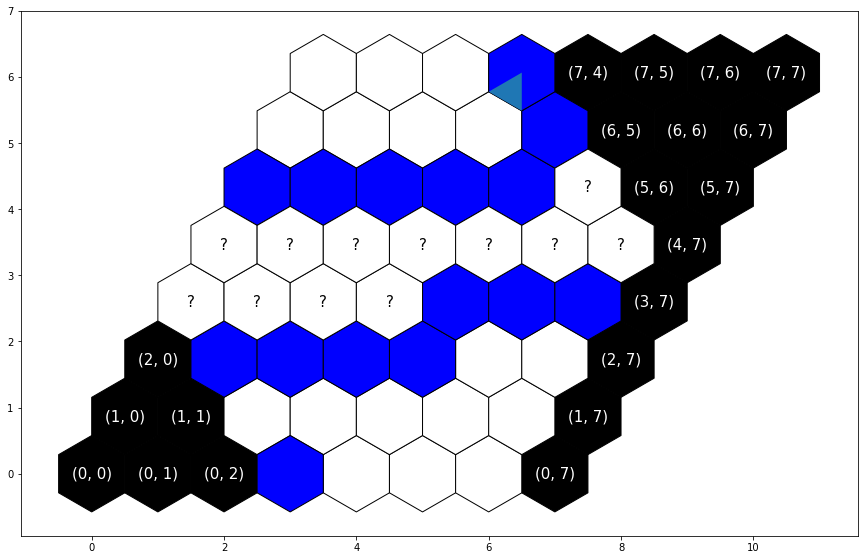

In [11]:
import matplotlib

def resource_sum(a : Resource, b : Resource, c : Resource):
    odd_sum = sum([1 for resource in [a, b, c] if resource.odd > 0])
    if odd_sum > 1:
        if a.odd + b.odd + c.odd < 11:
            return True
        else:
            return False
    else:
        return True

def resource_adjacent(a : Resource, b : Resource, c : Resource):
    resource_cnt = Counter([a.odd, b.odd, c.odd])
    if resource_cnt[5] > 1:
        return False
    else:
        return True

matplotlib.rcParams['figure.figsize'] = [15, 15]
rules = [resource_sum, resource_adjacent]
catan = FogIsland(rules)
catan.draw(default_gift=True)

In [12]:
resources = {
    ResourceType.Tree : 4,
    ResourceType.Grain : 3,
    ResourceType.Steel : 3,
    ResourceType.Sheep : 4,
    ResourceType.Ground : 3
}

number_dist = {
    2 : 1,
    3 : 2,
    4 : 2,
    5 : 2,
    6 : 2, 
    8 : 2,
    9 : 2,
    10 : 2,
    11 : 1,
    12 : 1
}

200th tries....
400th tries....
600th tries....
800th tries....
1000th tries....
1200th tries....
1400th tries....
1600th tries....
1800th tries....
2000th tries....
2200th tries....
2400th tries....
2600th tries....
2800th tries....
3000th tries....
3200th tries....
3400th tries....
3600th tries....
3800th tries....
4000th tries....
4200th tries....
4400th tries....
4600th tries....
4800th tries....
5000th tries....
5200th tries....
5400th tries....
5600th tries....
5800th tries....
6000th tries....
6200th tries....
6400th tries....
6600th tries....
6800th tries....
7000th tries....
7200th tries....
7400th tries....
7600th tries....
7800th tries....
8000th tries....
8200th tries....
8400th tries....
8600th tries....
8800th tries....
9000th tries....
9200th tries....
9400th tries....
9600th tries....
9800th tries....
10000th tries....
10200th tries....
10400th tries....
10600th tries....
10800th tries....
11000th tries....
11200th tries....
11400th tries....
11600th tries....
11800th t

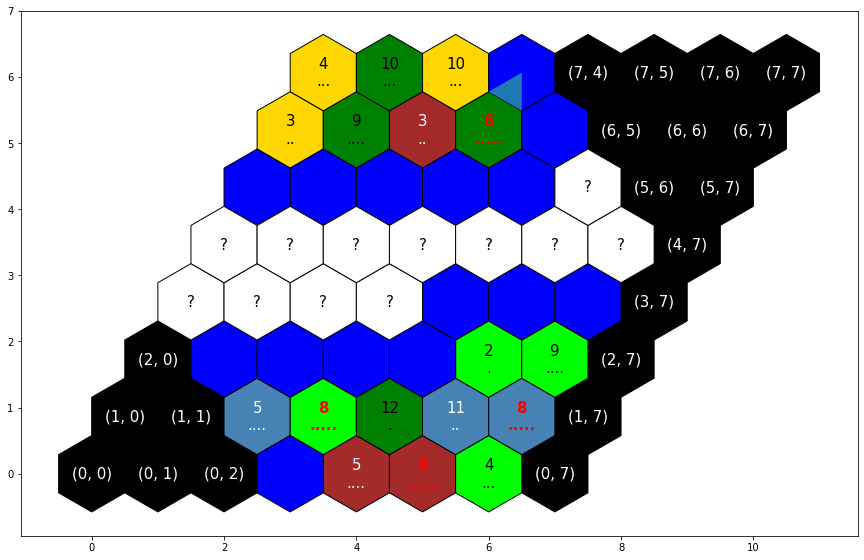

In [13]:
print(catan.generate(resources, number_dist))
catan.draw()